In [1]:
import string
import re
from numpy import array,argmax,random,take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Bidirectional,RepeatVector,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth',200)


ModuleNotFoundError: No module named 'keras'

In [6]:
def read_text(filename):
  file = open(filename,mode='rt',encoding='utf-8')
  text = file.read()
  file.close()
  return text

In [7]:
def to_lines(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [8]:
data = read_text("/content/EnglishToGerman.txt.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)


In [9]:
deu_eng = deu_eng[:50000,:]

In [10]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'GrÃ¼ÃŸ Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Who else is in there?', 'Wer ist noch dort drin?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3395974 (CK) & #3407455 (Pfirsichbaeumchen)'],
       ['Who else was in here?', 'Wer war sonst noch hier drin?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3434402 (CK) & #3610264 (Jan_Schreiber)'],
       ['Who fixed the window?', 'Wer hat das Fenster hergerichtet?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #9855581 (DJ_Saidez) & #9855585 (brauchinet)']],
      dtype='<U122')

In [11]:
eng_1 = []
deu_1 = []
for i in deu_eng[:,0]:
  eng_1.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_1.append(len(i.split()))
  

In [12]:
length_df = pd.DataFrame({'eng':eng_1,'deu':deu_1})

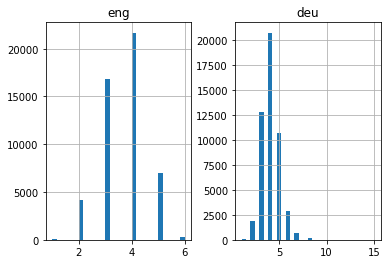

In [13]:
length_df.hist(bins=30)
plt.show()

In [14]:
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [15]:
eng_tokenizer=tokenization(deu_eng[:,0])
eng_vocab_size=len(eng_tokenizer.word_index)+1
eng_length=8
print('English Vocabulary Size: %d' % eng_vocab_size)


English Vocabulary Size: 6167


In [16]:
deu_tokenizer = tokenization(deu_eng[:,1])
deu_vocab_size = len(deu_tokenizer.word_index)+1

deu_length = 8
print('German Vocabulary Size: %d' % deu_vocab_size)

German Vocabulary Size: 10170


In [17]:
def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [19]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:,1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:,0])

In [20]:
testX = encode_sequences(deu_tokenizer, deu_length, train[:,1])
testY = encode_sequences(deu_tokenizer, deu_length, train[:,0])

In [21]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

In [22]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [23]:
filename ='model.h1.24_chetna'
checkpoint = ModelCheckpoint(filename, moniter='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=20, batch_size=512,
                    validation_split = 0.2,
                    callbacks=[checkpoint], verbose=1)

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 3.3704
Epoch 1: val_loss improved from inf to 2.81346, saving model to model.h1.24_chetna


63/63 [==============================] - 215s 3s/step - loss: 3.3704 - val_loss: 2.8135
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 2.7065

63/63 [==============================] - 208s 3s/step - loss: 2.7065 - val_loss: 2.6794
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 2.5381
Epoch 3: val_loss improved from 2.67941 to 2.50568, saving model to model.h1.24_chetna


63/63 [==============================] - 213s 3s/step - loss: 2.5381 - val_loss: 2.5057
Epoch 4/20
63/63 [==============================] - ETA: 0s - loss: 2.3697
Epoch 4: val_loss improved from 2.50568 to 2.39249, saving model to model.h1.24_chetna


63/63 [==============================] - 207s 3s/step - loss: 2.3697 - val_loss: 2.3925
Epoch 5/20
63/63 [==============================] - ETA: 0s - loss: 2.2186
Epoch 5: val_loss improved from 2.39249 to 2.24642, saving model to model.h1.24_chetna


63/63 [==============================] - 207s 3s/step - loss: 2.2186 - val_loss: 2.2464
Epoch 6/20
63/63 [==============================] - ETA: 0s - loss: 2.0727
Epoch 6: val_loss improved from 2.24642 to 2.14087, saving model to model.h1.24_chetna


63/63 [==============================] - 216s 3s/step - loss: 2.0727 - val_loss: 2.1409
Epoch 7/20
63/63 [==============================] - ETA: 0s - loss: 1.9488
Epoch 7: val_loss improved from 2.14087 to 2.06569, saving model to model.h1.24_chetna


63/63 [==============================] - 212s 3s/step - loss: 1.9488 - val_loss: 2.0657
Epoch 8/20
63/63 [==============================] - ETA: 0s - loss: 1.8350
Epoch 8: val_loss improved from 2.06569 to 1.97059, saving model to model.h1.24_chetna


63/63 [==============================] - 213s 3s/step - loss: 1.8350 - val_loss: 1.9706
Epoch 9/20
63/63 [==============================] - ETA: 0s - loss: 1.7284
Epoch 9: val_loss improved from 1.97059 to 1.91224, saving model to model.h1.24_chetna


63/63 [==============================] - 211s 3s/step - loss: 1.7284 - val_loss: 1.9122
Epoch 10/20
63/63 [==============================] - ETA: 0s - loss: 1.6264
Epoch 10: val_loss improved from 1.91224 to 1.83844, saving model to model.h1.24_chetna


63/63 [==============================] - 212s 3s/step - loss: 1.6264 - val_loss: 1.8384
Epoch 11/20
63/63 [==============================] - ETA: 0s - loss: 1.5298
Epoch 11: val_loss improved from 1.83844 to 1.79708, saving model to model.h1.24_chetna


63/63 [==============================] - 223s 4s/step - loss: 1.5298 - val_loss: 1.7971
Epoch 12/20
63/63 [==============================] - ETA: 0s - loss: 1.4365
Epoch 12: val_loss improved from 1.79708 to 1.71827, saving model to model.h1.24_chetna


63/63 [==============================] - 214s 3s/step - loss: 1.4365 - val_loss: 1.7183
Epoch 13/20
63/63 [==============================] - ETA: 0s - loss: 1.3472
Epoch 13: val_loss improved from 1.71827 to 1.65556, saving model to model.h1.24_chetna


63/63 [==============================] - 214s 3s/step - loss: 1.3472 - val_loss: 1.6556
Epoch 14/20
63/63 [==============================] - ETA: 0s - loss: 1.2640
Epoch 14: val_loss improved from 1.65556 to 1.62983, saving model to model.h1.24_chetna


63/63 [==============================] - 212s 3s/step - loss: 1.2640 - val_loss: 1.6298
Epoch 15/20
63/63 [==============================] - ETA: 0s - loss: 1.1843
Epoch 15: val_loss improved from 1.62983 to 1.57437, saving model to model.h1.24_chetna


63/63 [==============================] - 216s 3s/step - loss: 1.1843 - val_loss: 1.5744
Epoch 16/20
63/63 [==============================] - ETA: 0s - loss: 1.1088
Epoch 16: val_loss improved from 1.57437 to 1.53872, saving model to model.h1.24_chetna


63/63 [==============================] - 213s 3s/step - loss: 1.1088 - val_loss: 1.5387
Epoch 17/20
63/63 [==============================] - ETA: 0s - loss: 1.0363
Epoch 17: val_loss improved from 1.53872 to 1.50499, saving model to model.h1.24_chetna


63/63 [==============================] - 212s 3s/step - loss: 1.0363 - val_loss: 1.5050
Epoch 18/20
63/63 [==============================] - ETA: 0s - loss: 0.9669
Epoch 18: val_loss improved from 1.50499 to 1.45602, saving model to model.h1.24_chetna


63/63 [==============================] - 213s 3s/step - loss: 0.9669 - val_loss: 1.4560
Epoch 19/20
63/63 [==============================] - ETA: 0s - loss: 0.9023
Epoch 19: val_loss improved from 1.45602 to 1.43270, saving model to model.h1.24_chetna


63/63 [==============================] - 219s 3s/step - loss: 0.9023 - val_loss: 1.4327
Epoch 20/20
63/63 [==============================] - ETA: 0s - loss: 0.8375
Epoch 20: val_loss improved from 1.43270 to 1.40208, saving model to model.h1.24_chetna


63/63 [==============================] - 230s 4s/step - loss: 0.8375 - val_loss: 1.4021


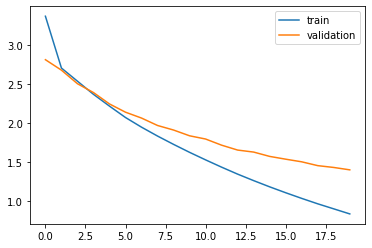

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model = load_model('model.h1.24_chetna')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

1250/1250 [==============================] - 108s 85ms/step


In [ ]:
def get_word(n, tokenizer): 
    for word, index in tokenizer.word_index.items(): 
        if index == n: 
           return word
    return None

In [ ]:
preds_text = [] 
for i in preds: 
    temp = [ ] 
    for j in range(len(i)): 
        t = get_word(i[j], eng_tokenizer) 
        if j > 0: 
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None): 
              temp.append(' ') 
            else:
              temp.append(t)
        else:
            if (t == None):
               temp.append(' ') 
            else: 
               temp.append(t) 
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [1]:
pred_df.head(15)

NameError: ignored